### **Setup**

In [1]:
%%bash
pip install timm -q
pip install onnx -q
pip install onnxruntime -q

### **Library Imports**

In [2]:
import os
import re
import cv2
import timm
import onnx
import torch
import random as r
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

from PIL import Image
from typing import Union
from IPython.display import clear_output

### **Helpers**

In [3]:
def breaker(num: int=50, char: str="*") -> None: print("\n" + num*char + "\n")
    

def get_image(path: str, size: int=224) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    if image is None: 
        image = np.asarray(Image.open(path))
        if len(image.shape) == 2:
            image = np.concatenate((
                np.expand_dims(image, axis=2),
                np.expand_dims(image, axis=2),
                np.expand_dims(image, axis=2),
            ), axis=2)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
    return cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)


def show_image(image: np.ndarray, cmap: str="gnuplot2", title: Union[str, None]=None) -> None:
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

### **PT Model**

In [4]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
            
        self.model = timm.create_model(model_name="efficientnet_b4", pretrained=False)
        self.model.classifier = torch.nn.Linear(in_features=self.model.classifier.in_features, out_features=6)

    def forward(self, x):
        return torch.nn.LogSoftmax(dim=1)(self.model(x))

### **ONNX Configuration**

In [5]:
class CFG(object):  
    def __init__(
        self, 
        in_channels: int=3, 
        size: int=256, 
        opset_version: int=9, 
        path: str=None
    ):
        self.in_channels = in_channels
        self.size = size
        self.dummy = torch.randn(1, self.in_channels, self.size, self.size)
        self.opset_version = opset_version
        self.path = path

### **PT to ONNX**

In [6]:
cfg = CFG(
    in_channels=3, 
    size=384, 
    opset_version=15, 
    path="../input/fdis-en4-a384/saves/ble_state_fold_1.pt"
)

model = Model()
model.load_state_dict(torch.load(cfg.path, map_location=torch.device("cpu"))["model_state_dict"])
model.eval()

clear_output()

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()

buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2

breaker()
print(f"Model size: {size_all_mb:.3f} MB")
breaker()


**************************************************

Model size: 67.462 MB

**************************************************



In [7]:
torch.onnx.export(
    model=model, 
    args=cfg.dummy, 
    f="fdis-model.onnx", 
    input_names=["input"], 
    output_names=["output"], 
    opset_version=cfg.opset_version,
    export_params=True,
    training=torch.onnx.TrainingMode.EVAL,
    operator_export_type=torch.onnx.OperatorExportTypes.ONNX,
    dynamic_axes={
      "input"  : {0 : "batch_size"},
      "output" : {0 : "batch_size"},
    }
)

### **Testing ONNX Model**

In [8]:
class OnnxModel(object):
    def __init__(self) -> None:
        self.ort_session = None
        self.size: int = 384
        
        self.mean: list = [0.65965, 0.62905, 0.59209]
        self.std: list  = [0.23497, 0.24317, 0.26674]
            
        self.path: str = "fdis-model.onnx"
            
        self.labels: dict = {
            0 : "donald",
            1 : "mickey",
            2 : "minion",
            3 : "olaf",
            4 : "pooh",
            5 : "pumba",
        }
            
        ort.set_default_logger_severity(3)
    
    def setup(self) -> None:
        model = onnx.load(self.path)
        onnx.checker.check_model(model)
        self.ort_session = ort.InferenceSession(self.path)
    
    def infer(self, image: np.ndarray) -> np.ndarray:
        h, w, _ = image.shape

        image = image / 255
        image = cv2.resize(src=image, dsize=(self.size, self.size), interpolation=cv2.INTER_AREA).transpose(2, 0, 1)
        for i in range(image.shape[0]): image[i, :, :] = (image[i, :, :] - self.mean[i]) / self.std[i]
        image = np.expand_dims(image, axis=0)
        input = {self.ort_session.get_inputs()[0].name : image.astype("float32")}
        return self.labels[np.argmax(self.ort_session.run(None, input))].title()

    
onnx_model = OnnxModel()
onnx_model.setup()


**************************************************



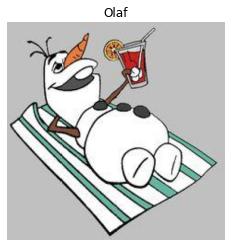


**************************************************



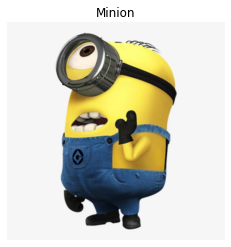


**************************************************



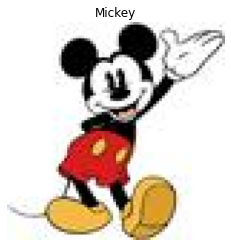


**************************************************



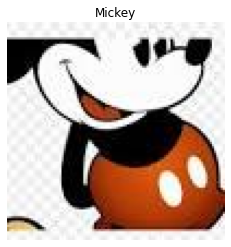


**************************************************



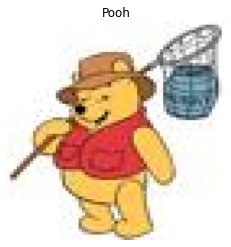


**************************************************



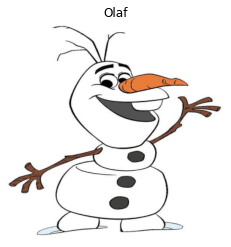


**************************************************



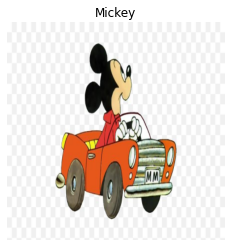


**************************************************



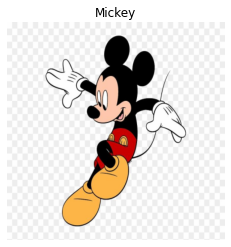


**************************************************



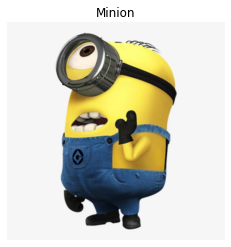


**************************************************



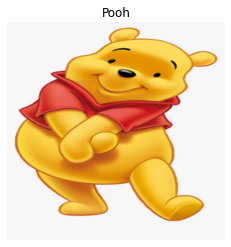


**************************************************



In [9]:
breaker()
for _ in range(10):
    index = r.randint(0, len(os.listdir("../input/finding-disney/test")))

    filename = os.listdir("../input/finding-disney/test")[index]

    image = get_image(f"../input/finding-disney/test/{filename}", cfg.size)

    label = onnx_model.infer(image)

    show_image(image, title=f"{label.title()}")
    breaker()